<a href="https://colab.research.google.com/github/debanjan02/BreakHis/blob/master/raw/magnification_100x/BreakHis_100_octal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from keras.utils import to_categorical
from sklearn.cluster import KMeans, estimate_bandwidth, MeanShift
from glob import glob
import cv2
import fnmatch

Using TensorFlow backend.


In [0]:
from google.colab import drive
drive.mount("/content/drive")

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
x = np.load('/content/drive/My Drive/project/x_BreakHis_100.npy')
y = np.load('/content/drive/My Drive/project/y_BreakHis_100_octal.npy')

In [0]:
from sklearn.model_selection import train_test_split
x_train, x_valid, y_train, y_valid = train_test_split(x, y, test_size = 0.2, random_state = 101)
y_train = to_categorical(y_train, num_classes = 8)
y_valid = to_categorical(y_valid, num_classes = 8)

In [0]:
import keras
from keras.models import Sequential,Input,Model
from keras.layers import Conv2D, MaxPooling2D, MaxPooling1D, GlobalAveragePooling2D, Dense, Dropout, Flatten, Input, LSTM, TimeDistributed
from keras.layers.normalization import BatchNormalization
from keras.layers.advanced_activations import LeakyReLU 
from keras.applications.inception_v3 import InceptionV3
input_tensor = Input(shape=(299,299,3))
base_model = InceptionV3(input_tensor = input_tensor, include_top = False, pooling = 'average')
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1000, activation = 'relu')(x)
x = Dense(8, activation = 'softmax')(x)
model = Model(base_model.input,x)
model.compile(optimizer='adam', loss = 'categorical_crossentropy', metrics=['accuracy'])
model.summary()

87916544/87910968 [==============================] - 4s 0us/step
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 299, 299, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 149, 149, 32) 96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 149, 149, 32) 0           batch_normalization_1[0][0]      
____________________________________________

In [0]:
from keras.callbacks import ModelCheckpoint
mcp = ModelCheckpoint(filepath='/content/drive/My Drive/project/model_check_path_BreakHis_100_octal_inception_v3',monitor="val_acc", save_best_only=True, save_weights_only=False)
hist = model.fit(x_train,y_train,batch_size = 32, epochs = 150, verbose=1,  validation_data=(x_valid, y_valid), callbacks=[mcp])

Train on 4994 samples, validate on 1249 samples
Epoch 1/150
4994/4994 [==============================] - 216s 43ms/step - loss: 1.4136 - acc: 0.5266 - val_loss: 3.0907 - val_acc: 0.1497
Epoch 2/150
4994/4994 [==============================] - 193s 39ms/step - loss: 1.0272 - acc: 0.6195 - val_loss: 3.5790 - val_acc: 0.3082
Epoch 3/150
4994/4994 [==============================] - 193s 39ms/step - loss: 0.7456 - acc: 0.7259 - val_loss: 1.8371 - val_acc: 0.4804
Epoch 4/150
4994/4994 [==============================] - 193s 39ms/step - loss: 0.5852 - acc: 0.7946 - val_loss: 2.2129 - val_acc: 0.6029
Epoch 5/150
4994/4994 [==============================] - 193s 39ms/step - loss: 0.4558 - acc: 0.8368 - val_loss: 1.2222 - val_acc: 0.6733
Epoch 6/150
4994/4994 [==============================] - 194s 39ms/step - loss: 0.3984 - acc: 0.8528 - val_loss: 2.0495 - val_acc: 0.5661
Epoch 7/150
4994/4994 [==============================] - 194s 39ms/step - loss: 0.3641 - acc: 0.8712 - val_loss: 3.2363 - va

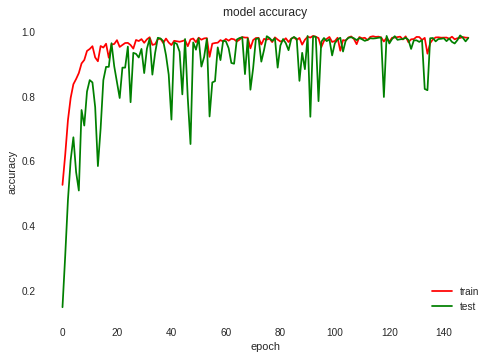

In [0]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_facecolor('w')
ax.grid(b=False)
ax.plot(hist.history['acc'], color='red')
ax.plot(hist.history['val_acc'], color ='green')
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='lower right')
plt.show()

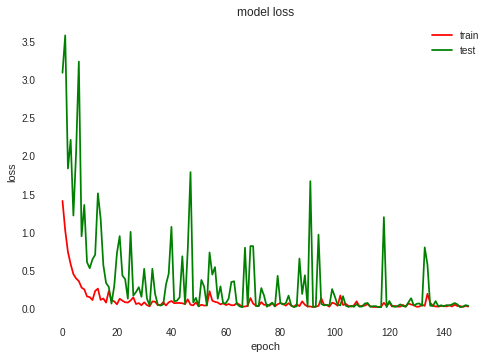

In [0]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_facecolor('w')
ax.grid(b=False)
ax.plot(hist.history['loss'], color='red')
ax.plot(hist.history['val_loss'], color ='green')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

In [0]:
model.load_weights('/content/drive/My Drive/project/model_check_path_BreakHis_100_octal_inception_v3')

In [0]:
from sklearn.metrics import classification_report
pred = model.predict(x_valid)
print(classification_report(np.argmax(y_valid, axis = 1),np.argmax(pred, axis = 1)))

In [0]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.grid(b=False)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

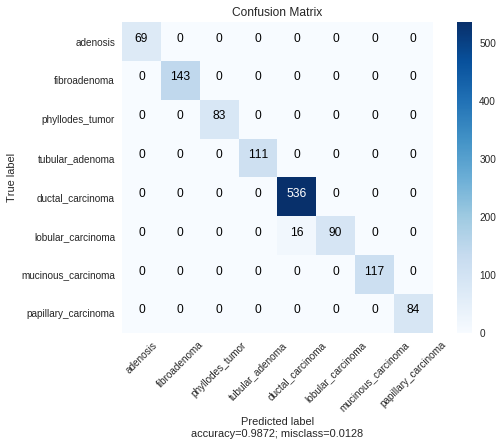

In [0]:

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(np.argmax(y_valid, axis = 1),np.argmax(pred, axis = 1))
plot_confusion_matrix(cm = cm,
                      normalize    = False,
                      target_names = ['adenosis', 'fibroadenoma', 'phyllodes_tumor', 'tubular_adenoma', 'ductal_carcinoma', 'lobular_carcinoma', 'mucinous_carcinoma', 'papillary_carcinoma'],
                      title        = "Confusion Matrix")